In [6]:
!pip install h2o 

     |████████████████████████████████| 176.2 MB 78 kB/s 
  Created wheel for h2o: filename=h2o-3.36.0.3-py2.py3-none-any.whl size=176244303 sha256=823ce2f4451f9ad2ed31fdce06bdd0dd336c51d0441cd530404e5549e0289c81
  Stored in directory: /root/.cache/pip/wheels/b5/71/a5/02087a05e5644158183e1c58eeae3f9356a4d1e80659fb2dfb
Successfully built h2o


In [9]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np                   
import io
from google.colab import files  
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch
%matplotlib inline
SEED = 12345 


In [11]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmplqevtkyk
  JVM stdout: /tmp/tmplqevtkyk/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmplqevtkyk/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_unknownUser_2fcjq0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [12]:
uploaded = files.upload()

Saving loan_clean.csv to loan_clean.csv


In [14]:
uploaded.keys()

dict_keys(['loan_clean.csv'])

In [15]:
raw = pd.read_csv(io.StringIO(uploaded['loan_clean.csv'].decode('utf-8'))) # name in quotes here must match name above

In [17]:
col_types = {'bad_loan': 'enum'}

In [18]:
hraw = h2o.H2OFrame(raw, column_types=col_types)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [19]:
train, valid, test = hraw.split_frame([0.4, 0.3])

In [20]:
y = 'bad_loan'
X = [name for name in train.columns if name not in ['id', '_WARN_', 'GRP_home_ownership', y]]
print(y)
print(X)

bad_loan
['GRP_REP_home_ownership', 'GRP_addr_state', 'GRP_purpose', 'GRP_verification_status', 'STD_IMP_REP_annual_inc', 'STD_IMP_REP_delinq_2yrs', 'STD_IMP_REP_dti', 'STD_IMP_REP_emp_length', 'STD_IMP_REP_int_rate', 'STD_IMP_REP_loan_amnt', 'STD_IMP_REP_longest_credit_lengt', 'STD_IMP_REP_revol_util', 'STD_IMP_REP_term_length', 'STD_IMP_REP_total_acc']


In [21]:
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()

# Training ANN

In [22]:
hyper_parameters = {'hidden':[[170, 320], [80, 190], [320, 160, 80], [100], [50, 50, 50, 50]], 
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}


search_criteria = {'strategy':'RandomDiscrete', 
                   'max_models': 20,
                   'max_runtime_secs': 1200,
                   'seed': SEED} 


gsearch = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)


gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid,
              reproducible = True, 
              seed=SEED) 

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
      ...   logloss
0     ...  0.458763
1     ...  0.460532
2     ...  0.461135
3     ...  0.461714
4     ...  0.463136
5     ...  0.489823
6     ...  0.489826
7     ...  0.489833
8     ...  0.489859
9     ...  0.489891
10    ...  0.490001
11    ...  0.490016
12    ...  0.490016
13    ...  0.490031
14    ...  0.490050
15    ...  0.490441
16    ...  0.490465
17    ...  0.491548
18    ...  0.492731
19    ...  0.502100

[20 rows x 7 columns]


In [23]:
gsearch.show()
best_ann = gsearch.get_grid()[0]
best_ann

      ...   logloss
0     ...  0.458763
1     ...  0.460532
2     ...  0.461135
3     ...  0.461714
4     ...  0.463136
5     ...  0.489823
6     ...  0.489826
7     ...  0.489833
8     ...  0.489859
9     ...  0.489891
10    ...  0.490001
11    ...  0.490016
12    ...  0.490016
13    ...  0.490031
14    ...  0.490050
15    ...  0.490441
16    ...  0.490465
17    ...  0.491548
18    ...  0.492731
19    ...  0.502100

[20 rows x 7 columns]
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  Grid_DeepLearning_py_5_sid_a478_model_python_1645910607226_1_model_17


Status of Neuron Layers: predicting bad_loan, 2-class classification, bernoulli distribution, CrossEntropy loss, 1,702 weights/biases, 27.0 KB, 656,210 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,14,Input,18.0,,,,,,,,,
1,,2,100,Rectifier,0.0,0.0,0.003,0.19873,0.165885,0.0,0.001032,0.039752,-0.018301,0.076354
2,,3,2,Softmax,,0.0,0.003,0.063733,0.055151,0.0,-0.00008,0.094385,-0.000372,0.421373




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.14658407402912366
RMSE: 0.382862996421858
LogLoss: 0.4620738200161364
Mean Per-Class Error: 0.37585561910570625
AUC: 0.6748044160266703
AUCPR: 0.33989144462233456
Gini: 0.3496088320533406

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24352298983518697: 


,,0.0,1.0,Error,Rate
0,0.0,5995.0,1989.0,0.2491,(1989.0/7984.0)
1,1.0,971.0,961.0,0.5026,(971.0/1932.0)
2,Total,6966.0,2950.0,0.2985,(2960.0/9916.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.243523,0.393691,168.0
1,max f2,0.098646,0.568261,326.0
2,max f0point5,0.303147,0.374724,121.0
3,max accuracy,0.464349,0.807685,27.0
4,max precision,0.496723,0.591837,15.0
5,max recall,0.022998,1.000000,397.0
6,max specificity,0.602475,0.999875,0.0
7,max absolute_mcc,0.272065,0.224467,144.0
8,max min_per_class_accuracy,0.195664,0.622153,214.0
9,max mean_per_class_accuracy,0.190495,0.624752,219.0



Gains/Lift Table: Avg response rate: 19.48 %, avg score: 19.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010085,0.475990,2.874203,2.874203,0.560000,0.503551,0.560000,0.503551,0.028986,0.028986,187.420290,187.420290,0.023474
1,2,0.020069,0.452066,2.488487,2.682314,0.484848,0.462208,0.522613,0.482983,0.024845,0.053830,148.848736,168.231426,0.041931
2,3,0.030052,0.432042,2.384800,2.583476,0.464646,0.441245,0.503356,0.469117,0.023810,0.077640,138.480038,158.347576,0.059103
3,4,0.040036,0.415218,2.540331,2.572717,0.494949,0.423227,0.501259,0.457674,0.025362,0.103002,154.033084,157.271670,0.078202
4,5,0.050020,0.403216,2.229270,2.504166,0.434343,0.409155,0.487903,0.447989,0.022257,0.125259,122.926992,150.416583,0.093445
5,6,0.100040,0.355352,1.800516,2.152341,0.350806,0.376894,0.419355,0.412441,0.090062,0.215321,80.051593,115.234088,0.143177
6,7,0.150061,0.321465,1.686690,1.997124,0.328629,0.337539,0.389113,0.387474,0.084369,0.299689,68.669021,99.712399,0.185837
7,8,0.200081,0.290237,1.562517,1.888472,0.304435,0.305520,0.367944,0.366986,0.078157,0.377847,56.251670,88.847217,0.220783
8,9,0.300020,0.242053,1.222272,1.666555,0.238143,0.265216,0.324706,0.333085,0.122153,0.500000,22.227167,66.655462,0.248372
9,10,0.400061,0.203072,0.931301,1.482695,0.181452,0.221796,0.288883,0.305256,0.093168,0.593168,-6.869866,48.269497,0.239836




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1455755118860933
RMSE: 0.38154359106934727
LogLoss: 0.458762927746261
Mean Per-Class Error: 0.3724450909012848
AUC: 0.6769093889100001
AUCPR: 0.32986126877303584
Gini: 0.35381877782000015

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20300552919181516: 


,,0.0,1.0,Error,Rate
0,0.0,25865.0,13891.0,0.3494,(13891.0/39756.0)
1,1.0,3748.0,5729.0,0.3955,(3748.0/9477.0)
2,Total,29613.0,19620.0,0.3583,(17639.0/49233.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.203006,0.393786,224.0
1,max f2,0.104855,0.565459,324.0
2,max f0point5,0.301006,0.357183,139.0
3,max accuracy,0.492950,0.808238,21.0
4,max precision,0.521620,0.650602,13.0
5,max recall,0.025981,1.000000,396.0
6,max specificity,0.636014,0.999975,0.0
7,max absolute_mcc,0.203006,0.205434,224.0
8,max min_per_class_accuracy,0.194978,0.627352,231.0
9,max mean_per_class_accuracy,0.192945,0.627723,233.0



Gains/Lift Table: Avg response rate: 19.25 %, avg score: 19.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010014,0.473818,2.739756,2.739756,0.527383,0.500608,0.527383,0.500608,0.027435,0.027435,173.975576,173.975576,0.021574
1,2,0.020007,0.448953,2.322967,2.531573,0.447154,0.460785,0.487310,0.480717,0.023214,0.050649,132.296677,153.157283,0.037946
2,3,0.030000,0.429498,2.301849,2.455050,0.443089,0.439151,0.472580,0.466871,0.023003,0.073652,130.184889,145.505003,0.054057
3,4,0.040014,0.415324,2.107504,2.368075,0.405680,0.422277,0.455838,0.455711,0.021104,0.094756,110.750443,136.807542,0.067791
4,5,0.050007,0.403800,2.154024,2.325300,0.414634,0.409273,0.447604,0.446431,0.021526,0.116282,115.402373,132.529986,0.082073
5,6,0.100014,0.354081,1.909616,2.117458,0.367587,0.377005,0.407595,0.411718,0.095494,0.211776,90.961558,111.745772,0.138403
6,7,0.150001,0.317962,1.589530,1.941530,0.305973,0.335366,0.373731,0.386274,0.079456,0.291231,58.953019,94.152954,0.174897
7,8,0.200008,0.287850,1.508702,1.833312,0.290414,0.302506,0.352899,0.365330,0.075446,0.366677,50.870181,83.331162,0.206400
8,9,0.300002,0.239356,1.227256,1.631307,0.236238,0.262529,0.314015,0.331065,0.122718,0.489395,22.725638,63.130688,0.234541
9,10,0.399996,0.201657,1.162886,1.514208,0.223847,0.219735,0.291474,0.303234,0.116282,0.605677,16.288610,51.420763,0.254711




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-02-26 21:48:31,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-02-26 21:48:33,14 min 49.938 sec,28743 obs/sec,1.0,1,65621.0,0.387277,0.471759,0.043934,0.655424,0.310043,2.514928,0.414280,0.386296,0.469308,0.039980,0.654548,0.300890,2.265567,0.402372
2,,2022-02-26 21:48:36,14 min 52.144 sec,31632 obs/sec,2.0,2,131242.0,0.384541,0.465394,0.057393,0.666650,0.326866,2.566253,0.372328,0.382637,0.461192,0.058081,0.670451,0.320470,2.518468,0.400605
3,,2022-02-26 21:48:37,14 min 53.942 sec,35110 obs/sec,3.0,3,196863.0,0.383293,0.463167,0.063499,0.673117,0.335146,2.822878,0.337233,0.381698,0.459410,0.062701,0.675502,0.329555,2.644918,0.382426
4,,2022-02-26 21:48:39,14 min 55.497 sec,38521 obs/sec,4.0,4,262484.0,0.383072,0.462379,0.064582,0.674211,0.337200,2.822878,0.339552,0.381960,0.459822,0.061412,0.674111,0.326570,2.687068,0.372332
5,,2022-02-26 21:48:40,14 min 56.881 sec,41807 obs/sec,5.0,5,328105.0,0.383108,0.462492,0.064405,0.673906,0.338701,2.617578,0.355990,0.381879,0.459485,0.061811,0.674671,0.327934,2.771368,0.362074
6,,2022-02-26 21:48:42,14 min 58.213 sec,44544 obs/sec,6.0,6,393726.0,0.383180,0.462551,0.064055,0.674759,0.340916,2.874203,0.346410,0.381901,0.459208,0.061700,0.677264,0.327543,2.634381,0.376495
7,,2022-02-26 21:48:43,14 min 59.498 sec,46963 obs/sec,7.0,7,459347.0,0.382863,0.462074,0.065601,0.674804,0.339891,2.874203,0.298507,0.381544,0.458763,0.063458,0.676909,0.329861,2.739756,0.358276
8,,2022-02-26 21:48:44,15 min 0.807 sec,49251 obs/sec,8.0,8,524968.0,0.383055,0.462601,0.064663,0.673442,0.341198,3.130828,0.344393,0.381756,0.459108,0.062414,0.676060,0.326736,2.592230,0.342250
9,,2022-02-26 21:48:46,15 min 2.080 sec,51226 obs/sec,9.0,9,590589.0,0.383700,0.463659,0.061513,0.675004,0.340485,2.976853,0.306777,0.382462,0.460784,0.058942,0.676226,0.325882,2.676531,0.377592



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,STD_IMP_REP_int_rate,1.000000,1.000000,0.127163
1,STD_IMP_REP_annual_inc,0.774378,0.774378,0.098472
2,STD_IMP_REP_term_length,0.611914,0.611914,0.077813
3,STD_IMP_REP_dti,0.606320,0.606320,0.077101
4,STD_IMP_REP_delinq_2yrs,0.551468,0.551468,0.070126
5,STD_IMP_REP_revol_util,0.526463,0.526463,0.066946
6,GRP_purpose,0.520631,0.520631,0.066205
7,GRP_REP_home_ownership,0.513194,0.513194,0.065259
8,STD_IMP_REP_loan_amnt,0.500435,0.500435,0.063637
9,STD_IMP_REP_emp_length,0.475208,0.475208,0.060429


In [24]:
# measure ann AUC
print('Training AUC:',best_ann.auc(train = True))
print('Validation AUC:', best_ann.auc(valid = True))
print('Test AUC:', best_ann.model_performance(test_data = test).auc())

Training AUC: 0.6748044160266703
Validation AUC: 0.6769093889100001
Test AUC: 0.6835873288437015


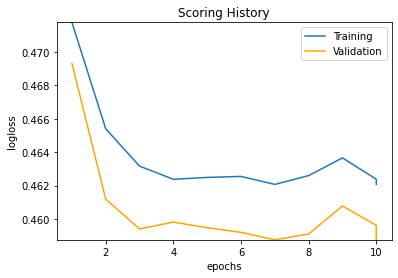

In [25]:
_ = best_ann.plot()

In [26]:

new_row = pd.DataFrame.from_dict({
  "GRP_REP_home_ownership": [1],
  "GRP_addr_state": [20],
  "GRP_purpose": [1],
  "GRP_verification_status": [1],
  "STD_IMP_REP_annual_inc": [4],
  "STD_IMP_REP_delinq_2yrs": [1],
  "STD_IMP_REP_dti": [1],
  "STD_IMP_REP_emp_length": [2],
  "STD_IMP_REP_int_rate": [1],
  "STD_IMP_REP_loan_amnt": [1],
  "STD_IMP_REP_longest_credit_lengt": [1],
  "STD_IMP_REP_revol_util": [1],
  "STD_IMP_REP_term_length":[1],
  "STD_IMP_REP_total_acc": [0]},
  orient='columns')


best_ann.predict(h2o.H2OFrame(new_row))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


predict,0.0,1.0
0,0.870541,0.129459


In [27]:
h2o.cluster().shutdown(prompt = False)

H2O session _sid_a478 closed.
